## Importing Required Libraries:

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical
from IPython.display import display
from IPython.display import Image
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

In [2]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [3]:
df = pd.read_csv("fer2013.csv")

In [4]:
df.head()

,emotion,pixels,Usage
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...,Training
1,0,151 150 147 155 148 133 111 140 170 174 182 15...,Training
2,2,231 212 156 164 174 138 161 173 182 200 106 38...,Training
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...,Training
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...,Training


In [5]:
len(df)

35887

<AxesSubplot:>

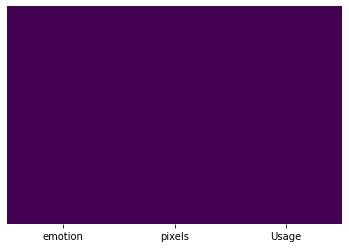

In [6]:
## Checking for presence of NULL values

sns.heatmap(df.isnull(), yticklabels=False, cbar=False, cmap='viridis') # no null values

In [7]:
emotions_mapping_dict = {0:"Angry", 1:"Disgust", 2:"Fear", 3:"Happy", 4:"Sad", 5:"Surprize", 6:"Neutral"}

In [8]:
value_counts_emotions = (df.groupby(by='emotion').count())
value_counts_emotions['class'] = [i for i in emotions_mapping_dict.values()]
value_counts_emotions.rename(columns={'pixels': 'count'}, inplace=True)
value_counts_emotions.drop(columns='Usage', inplace=True)
value_counts_emotions

,count,class
emotion,,
0,4953,Angry
1,547,Disgust
2,5121,Fear
3,8989,Happy
4,6077,Sad
5,4002,Surprize
6,6198,Neutral


In [9]:
df['Usage'].value_counts()

Training       28709
PublicTest      3589
PrivateTest     3589
Name: Usage, dtype: int64

In [10]:
def show_images(df, num_images):

    plt.figure(figsize=(15,15))

    random_idxs = np.random.randint(low=0, high=len(df), size=num_images)

    for count,i in enumerate(random_idxs, start=1):
        current_img = np.array([j for j in  df['pixels'][i].split()], dtype='float')  # coz the pixels are space seperated
        current_img = current_img.reshape(48, 48)
        ax = plt.subplot(4, 4, count)
        plt.imshow(current_img, cmap='gray')
        plt.title(emotions_mapping_dict[df['emotion'][i]])
        plt.axis("off")

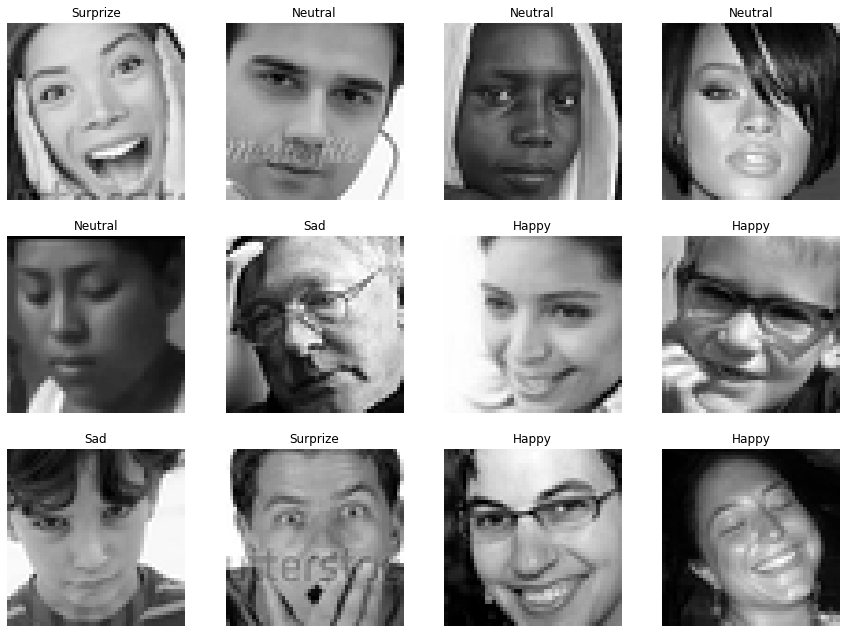

In [11]:
show_images(df=df, num_images=12)

## Preparing the Data

In [12]:
X_train = np.array(list(map(str.split, df[df['Usage']=='Training']['pixels'])), dtype=np.float32).reshape(-1,48,48,1)
X_train/=255
y_train = to_categorical(df[df['Usage']=='Training']['emotion'], num_classes=7)


X_validation = np.array(list(map(str.split, df[df['Usage']=='PublicTest']['pixels'])), dtype=np.float32).reshape(-1,48,48,1)
X_validation/=255
y_validation = to_categorical(df[df['Usage']=='PublicTest']['emotion'], num_classes=7)


X_test = np.array(list(map(str.split, df[df['Usage']=='PrivateTest']['pixels'])), dtype=np.float32).reshape(-1,48,48,1)
X_test/=255
y_test = to_categorical(df[df['Usage']=='PrivateTest']['emotion'], num_classes=7)

In [13]:
X_train.shape, y_train.shape, X_validation.shape, y_validation.shape, X_test.shape, y_test.shape

((28709, 48, 48, 1),
 (28709, 7),
 (3589, 48, 48, 1),
 (3589, 7),
 (3589, 48, 48, 1),
 (3589, 7))

In [14]:
train_datagen = ImageDataGenerator(rotation_range=20, width_shift_range=0.2, height_shift_range=0.2, 
                                   zoom_range=0.2, horizontal_flip=True)


validation_datagen = ImageDataGenerator(rotation_range=20, width_shift_range=0.2, height_shift_range=0.2, 
                                   zoom_range=0.2, horizontal_flip=True)

In [15]:
train_generator = train_datagen.flow(X_train, y_train, batch_size=32)
validation_generator = validation_datagen.flow(X_validation, y_validation, batch_size=32)

In [16]:
len(train_generator), len(validation_generator) 

(898, 113)

## Model Creation

In [17]:
from tensorflow.keras.layers import Dense, Dropout, Conv2D, MaxPooling2D, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.utils import plot_model

In [18]:
feature_extractor = Sequential()

feature_extractor.add(Conv2D(16, (3, 3), padding='same', activation='relu', input_shape=(48,48,1)))
feature_extractor.add(Conv2D(16, (3, 3), padding='same', activation='relu'))
feature_extractor.add(BatchNormalization())
feature_extractor.add(Dropout(0.2))

feature_extractor.add(Conv2D(32, (3, 3), padding='same', activation='relu'))
feature_extractor.add(Conv2D(32, (3, 3), padding='same', activation='relu'))
feature_extractor.add(BatchNormalization())
feature_extractor.add(MaxPooling2D((3, 3), strides=(2, 2)))
feature_extractor.add(Dropout(0.2))

feature_extractor.add(Conv2D(64, (3, 3), padding='same', activation='relu'))
feature_extractor.add(Conv2D(64, (3, 3), padding='same', activation='relu'))
feature_extractor.add(BatchNormalization())
feature_extractor.add(Dropout(0.2))

feature_extractor.add(Conv2D(128, (3, 3), padding='same', activation='relu'))
feature_extractor.add(Conv2D(128, (3, 3), padding='same', activation='relu'))
feature_extractor.add(BatchNormalization())
feature_extractor.add(MaxPooling2D((3, 3), strides=(2, 2)))
feature_extractor.add(Dropout(0.2))

feature_extractor.add(Conv2D(256, (3, 3), padding='same', activation='relu'))
feature_extractor.add(Conv2D(256, (3, 3), padding='same', activation='relu'))
feature_extractor.add(BatchNormalization())
feature_extractor.add(MaxPooling2D((3, 3), strides=(2, 2)))
feature_extractor.add(Dropout(0.2))

feature_extractor.add(GlobalAveragePooling2D())

x = feature_extractor.output  
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(256, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
output = Dense(7, activation='softmax')(x)

# Make a new model combining both feature extractor and x
model = Model(inputs=feature_extractor.input, outputs=output, name='Emotion_Recognition_Conv_fer_csv_data_With_Aug')
optimizer_ = tf.keras.optimizers.Adam(lr=0.01)

model.compile(loss=tf.keras.losses.categorical_crossentropy, optimizer=optimizer_, 
              metrics=['accuracy', tf.keras.metrics.AUC(name='auc_score')])

model.summary()

Model: "Emotion_Recognition_Conv_fer_csv_data_With_Aug"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_input (InputLayer)   [(None, 48, 48, 1)]       0         
                                                                 
 conv2d (Conv2D)             (None, 48, 48, 16)        160       
                                                                 
 conv2d_1 (Conv2D)           (None, 48, 48, 16)        2320      
                                                                 
 batch_normalization (BatchN  (None, 48, 48, 16)       64        
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 48, 48, 16)        0         
                                                                 
 conv2d_2 (Conv2D)           (None, 48, 48, 32)        4640      
                    

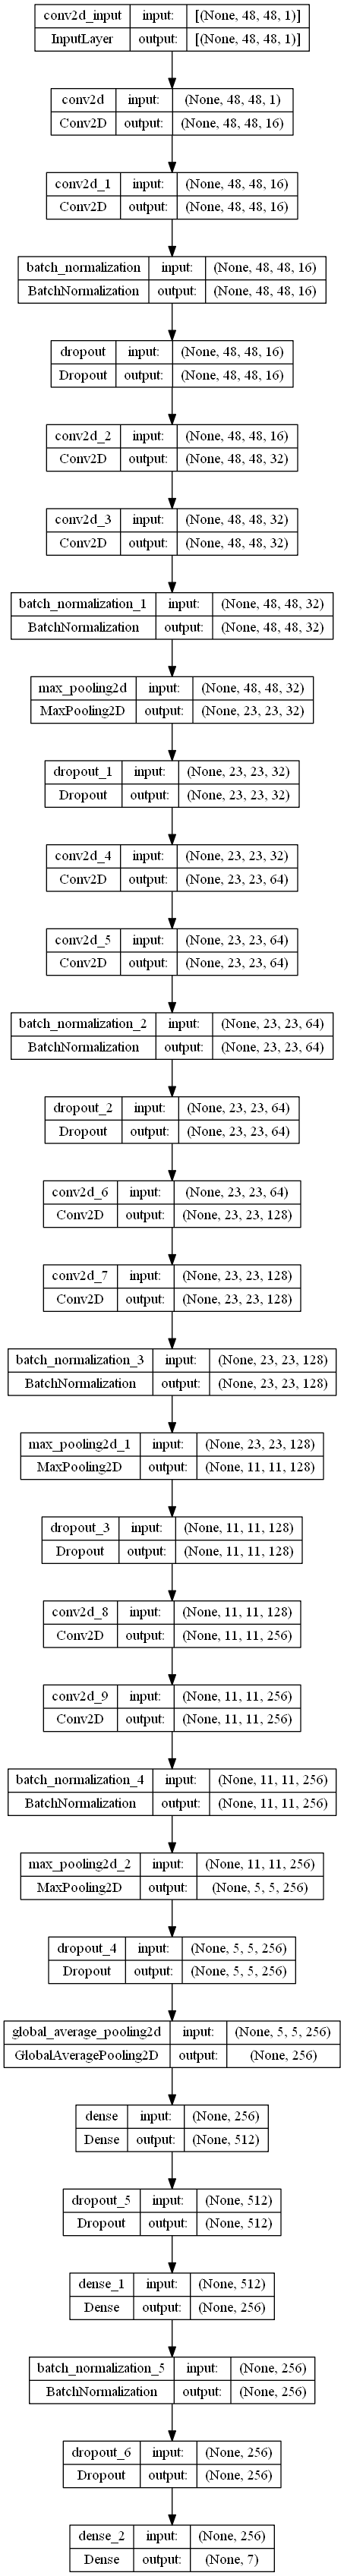

In [19]:
plot_model(model, to_file='Emotion_Recognition_Conv_fer_csv_data_With_Aug.png', show_shapes=True, show_layer_names=True)

In [20]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from livelossplot import PlotLossesKeras
from datetime import datetime

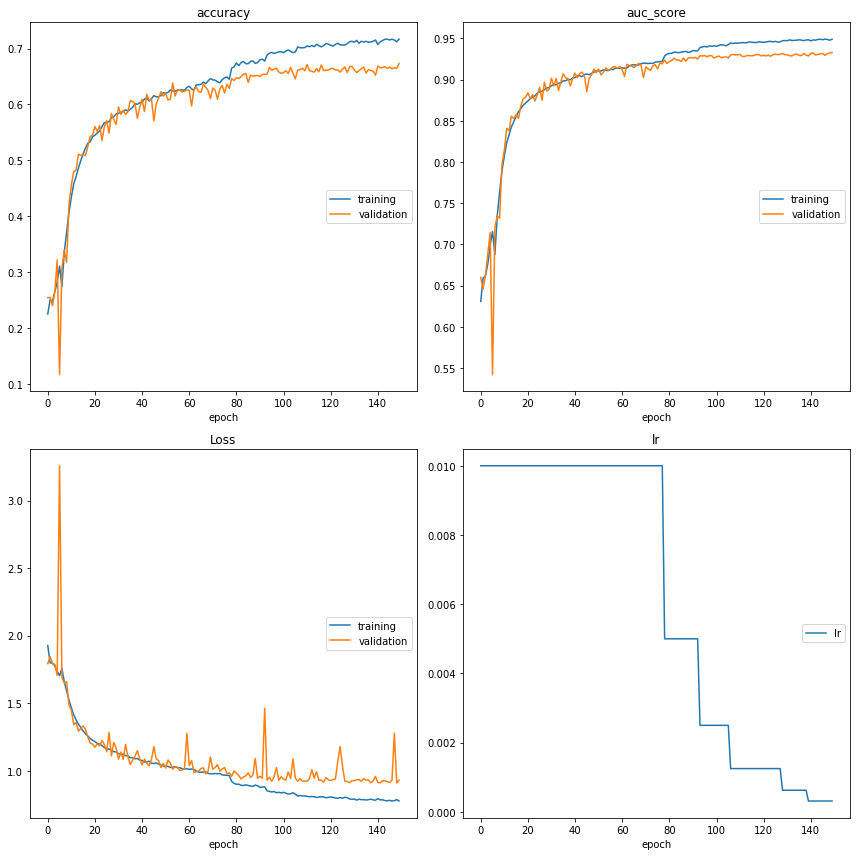

accuracy
	training         	 (min:    0.225, max:    0.717, cur:    0.717)
	validation       	 (min:    0.117, max:    0.673, cur:    0.673)
auc_score
	training         	 (min:    0.631, max:    0.949, cur:    0.949)
	validation       	 (min:    0.542, max:    0.933, cur:    0.933)
Loss
	training         	 (min:    0.776, max:    1.927, cur:    0.776)
	validation       	 (min:    0.910, max:    3.258, cur:    0.930)
lr
	lr               	 (min:    0.000, max:    0.010, cur:    0.000)
898/898 [==============================] - 33s 37ms/step - loss: 0.7765 - accuracy: 0.7167 - auc_score: 0.9490 - val_loss: 0.9298 - val_accuracy: 0.6732 - val_auc_score: 0.9329 - lr: 3.1250e-04
Training completed in 1:26:02.887656


In [21]:
checkpointer = ModelCheckpoint(filepath = 'saved_checkpoints/Emotion_Recognition_Conv_fer_csv_data_With_Aug_/checkpoint', verbose=1, save_best_only=True, 
                               monitor='val_loss', mode='min', save_weights_only=True)

early_stop = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=25)


reduce_lr_on_plateau = ReduceLROnPlateau(monitor='val_loss', factor=0.5, mode='min', patience=10, verbose=1, min_lr=0.00005)


start = datetime.now()


trained_model = model.fit_generator(train_generator, epochs=150, validation_data=validation_generator, 
                                    steps_per_epoch=len(train_generator), validation_steps=len(validation_generator), 
                                    callbacks=[checkpointer, early_stop, reduce_lr_on_plateau, PlotLossesKeras()], verbose=1)


duration = datetime.now() - start

print("Training completed in {}".format(duration))

In [22]:
model.load_weights('saved_checkpoints/Emotion_Recognition_Conv_fer_csv_data_With_Aug_/checkpoint')

In [23]:
model.save("models/Emotion_Recognition_Conv_fer_csv_data_With_Aug_.h5")

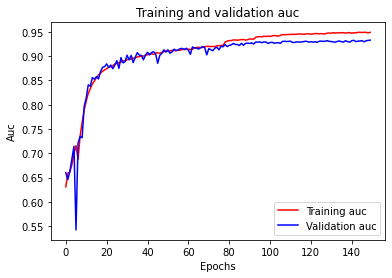

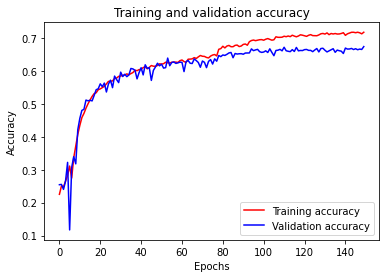

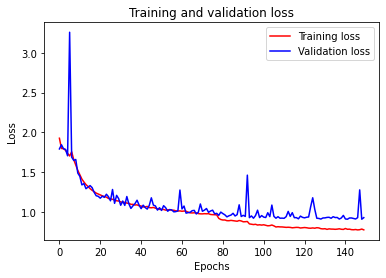

In [24]:
import matplotlib.pyplot as plt

auc_score = trained_model.history['auc_score']
accuracy = trained_model.history['accuracy']
val_auc_score = trained_model.history['val_auc_score']
val_accuracy = trained_model.history['val_accuracy']
loss = trained_model.history['loss']
val_loss = trained_model.history['val_loss']
epochs = list(range(0,150))

plt.plot(epochs, auc_score, 'r', label='Training auc')
plt.plot(epochs, val_auc_score, 'b', label='Validation auc')
plt.title('Training and validation auc')
plt.xlabel('Epochs')
plt.ylabel('Auc')
plt.legend()

plt.figure()
plt.plot(epochs, accuracy, 'r', label='Training accuracy')
plt.plot(epochs, val_accuracy, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.figure()
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [25]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, precision_recall_fscore_support, ConfusionMatrixDisplay

In [26]:
val_loss, val_accuracy, val_auc_score = model.evaluate(X_validation, y_validation)
print("val_loss = {}, val_accuracy = {}, and val_auc_score = {}".format(val_loss, val_accuracy, val_auc_score))

113/113 [==============================] - 1s 12ms/step - loss: 0.8825 - accuracy: 0.6885 - auc_score: 0.9370
val_loss = 0.8824687600135803, val_accuracy = 0.6884925961494446, and val_auc_score = 0.937038004398346


In [27]:
test_loss, test_accuracy, test_auc_score = model.evaluate(X_test, y_test)
print("Test_loss = {}, Test_accuracy = {}, and Test_auc_score = {}".format(test_loss, test_accuracy, test_auc_score))

113/113 [==============================] - 1s 11ms/step - loss: 0.9396 - accuracy: 0.7021 - auc_score: 0.9418
Test_loss = 0.9395946860313416, Test_accuracy = 0.7021454572677612, and Test_auc_score = 0.9418100118637085


In [28]:
test_predictions =  model.predict(X_test) 

113/113 [==============================] - 1s 10ms/step


In [29]:
test_predictions[0]

array([6.7010856e-01, 2.8341132e-01, 1.8516967e-02, 8.0103418e-05,
       2.4007879e-02, 1.2855179e-03, 2.5896470e-03], dtype=float32)

In [30]:
test_predictions = np.argmax(test_predictions, axis=1)
test_predictions

array([0, 4, 2, ..., 0, 3, 0], dtype=int64)

In [31]:
y_test = np.argmax(y_test, axis=1)
y_test

array([0, 5, 6, ..., 0, 3, 2], dtype=int64)

In [32]:
mapping_dict = {"angry":0, "disgust":1, "fear":2, "happy":3, "neutral":4, "sad":5, "surprise":6}
target_classes=[]

for i in mapping_dict.keys():
    target_classes.append(i)

In [33]:
#test data's metrics

print(confusion_matrix(y_test, test_predictions))
print('\n')
macroF1 = precision_recall_fscore_support(y_test, test_predictions, average='macro')
microF1 = precision_recall_fscore_support(y_test, test_predictions, average='micro')
print("Marco Precision Recall & F1 Scores: {}".format(macroF1))
print("Micro Precision Recall & F1 Scores: {}".format(microF1))
print("\n")
print(classification_report(y_test, test_predictions, target_names=target_classes))

[[313   4  41   6  62   4  61]
 [  9  37   3   1   1   1   3]
 [ 72   3 236  10  92  51  64]
 [ 11   1  11 786  17  17  36]
 [ 52   2  44  23 319   7 147]
 [ 11   0  39  19   4 338   5]
 [ 23   2  27  21  53   9 491]]


Marco Precision Recall & F1 Scores: (0.6958340932991124, 0.6836073640896123, 0.6862554899675394, None)
Micro Precision Recall & F1 Scores: (0.7021454444134857, 0.7021454444134857, 0.7021454444134857, None)


              precision    recall  f1-score   support

       angry       0.64      0.64      0.64       491
     disgust       0.76      0.67      0.71        55
        fear       0.59      0.45      0.51       528
       happy       0.91      0.89      0.90       879
     neutral       0.58      0.54      0.56       594
         sad       0.79      0.81      0.80       416
    surprise       0.61      0.78      0.69       626

    accuracy                           0.70      3589
   macro avg       0.70      0.68      0.69      3589
weighted avg       0.70      0

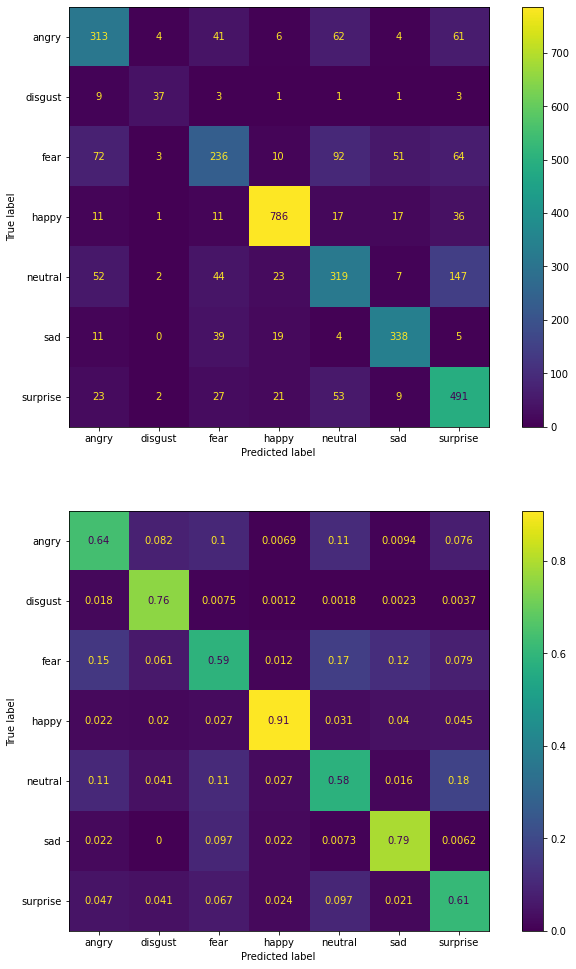

In [34]:
#plotting the confusion matrix for validation data:

fig, (ax1, ax2) = plt.subplots(2, figsize=(12,17))
cm_plot_1 = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_test, test_predictions), display_labels=target_classes)
cm_plot_2 = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_test, test_predictions, normalize='pred'), display_labels=target_classes)
cm_plot_1.plot(ax=ax1)
cm_plot_2.plot(ax=ax2)

plt.show()